In [53]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import dir_constants as dc
from tqdm import tqdm
from j_utils import munging as mg
from j_utils import eval_results as er
import lc_utils
# from fastai.structured import *

pd.options.display.max_columns = 999
# pd.options.display.max_rows = 999
pd.options.display.max_seq_items = None
# np.set_printoptions(threshold=100)

In [3]:
PATH = dc.data_path
project = 'lendingclub'
fname_base_loan = 'base_loan_info.fth'
fname_eval_loan = 'eval_loan_info.fth'
fname_str_loan = 'str_loan_info.fth'
fname_scl_pmt = 'scaled_pmt_hist.fth'
data_path = f'{PATH}{project}'

In [4]:
# load in and drop fico low
base_loan_info = pd.read_feather(f'{data_path}/base_loan_info.fth')
base_loan_info.drop('fico_range_low', axis=1, inplace=True)
eval_loan_info = pd.read_feather(f'{data_path}/eval_loan_info.fth')
str_loan_info = pd.read_feather(f'{data_path}/str_loan_info.fth')
# base_loan_info = pd.read_feather(f'{data_path}/base_loan_info_w_newfeats.fth')

In [5]:
# add in some more ratio features
lc_utils.add_custom_lc_features(base_loan_info)

In [7]:
base_loan_info, eval_loan_info = lc_utils.split_out_traintestable_loans(base_loan_info, eval_loan_info)

In [8]:
cut_date = lc_utils.get_split_date(eval_loan_info, 'issue_d', .8)

In [9]:
test_ids = eval_loan_info[eval_loan_info['issue_d'] >= cut_date]['id'].values
test_df = base_loan_info[base_loan_info['id'].isin(test_ids)].copy()
train_df = base_loan_info[~base_loan_info['id'].isin(test_ids)].copy()
train_ids = train_df['id'].values

# justin via munging

In [10]:
print(train_df.shape, train_df.dtypes.value_counts(dropna=False))
train_df, max_dict, min_dict, new_null_colnames, fill_dict, cats_dict, norm_dict = mg.train_proc(train_df, normalize=True, verbose=False)
print(train_df.shape, train_df.dtypes.value_counts(dropna=False))

(916089, 107) float64           91
object            12
int64              2
datetime64[ns]     2
dtype: int64
(916089, 162) float64    81
int64      68
int8       10
bool        2
int16       1
dtype: int64


In [11]:
print(test_df.shape, test_df.dtypes.value_counts(dropna=False))
test_df = mg.val_test_proc(test_df, train_df.columns, max_dict, min_dict, fill_dict, cats_dict, norm_dict=norm_dict, verbose=False)
print(test_df.shape, test_df.dtypes.value_counts(dropna=False))

(235079, 107) float64           91
object            12
int64              2
datetime64[ns]     2
dtype: int64
(235079, 162) float64    120
int64       29
int8        10
bool         2
int16        1
dtype: int64


In [12]:
train_df.loc[[0,4],:]

,application_type,inq_last_12m,num_bc_tl,num_rev_accts,tot_coll_amt,bc_util,open_rv_24m,num_bc_sats,mths_since_rcnt_il,mths_since_last_delinq,max_bal_bc,num_il_tl,mo_sin_rcnt_tl,purpose,sub_grade,total_bal_ex_mort,acc_now_delinq,id,num_tl_90g_dpd_24m,dti,mths_since_recent_bc,open_act_il,delinq_amnt,inq_last_6_mths,mths_since_last_major_derog,mo_sin_old_il_acct,open_acc,acc_open_past_24_mths,annual_inc,total_bc_limit,addr_state,revol_bal,open_acc_6m,is_inc_v,mths_since_recent_revol_delinq,annual_inc_joint,all_util,total_il_high_credit_limit,num_accts_ever_12_0_ppd,open_il_24m,num_tl_12_0dpd_2m,total_bal_il,i_l_util,open_rv_12m,mths_since_recent_inq,num_sats,tax_liens,mths_since_recent_bc_dlq,num_actv_bc_tl,num_actv_rev_tl,total_acc,pct_tl_nvr_dlq,total_rev_hi_lim,mths_since_last_record,num_tl_30dpd,pub_rec,tot_hi_cred_lim,delinq_2_yrs,term,loan_amount,total_cu_tl,fico_range_high,avg_cur_bal,chargeoff_within_12_mths,grade,open_il_12m,tot_cur_bal,collections_12_mths_ex_med,pub_rec_bankruptcies,installment,num_tl_op_past_12m,dti_joint,mo_sin_rcnt_rev_tl_op,int_rate,emp_length,inq_fi,disbursement_method,num_op_rev_tl,revol_util,percent_bc_gt_75,num_rev_tl_bal_gt_0,addr_zip,bc_open_to_buy,home_ownership,mort_acc,initial_list_status,mo_sin_old_rev_tl_op,monthly_inc,dti_w_loan,delinq_to_monthly_inc,tot_cur_bal_to_monthly_inc,loan_to_inc,earliest_cr_lineYear,earliest_cr_lineMonth,earliest_cr_lineWeek,earliest_cr_lineDayofweek,earliest_cr_lineDayofyear,earliest_cr_lineIs_quarter_start,earliest_cr_lineIs_year_start,inq_last_12m_isnull,num_bc_tl_isnull,num_rev_accts_isnull,tot_coll_amt_isnull,bc_util_isnull,open_rv_24m_isnull,num_bc_sats_isnull,mths_since_rcnt_il_isnull,mths_since_last_delinq_isnull,max_bal_bc_isnull,num_il_tl_isnull,mo_sin_rcnt_tl_isnull,total_bal_ex_mort_isnull,num_tl_90g_dpd_24m_isnull,dti_isnull,mths_since_recent_bc_isnull,open_act_il_isnull,mths_since_last_major_derog_isnull,mo_sin_old_il_acct_isnull,acc_open_past_24_mths_isnull,total_bc_limit_isnull,is_inc_v_joint_isnull,open_acc_6m_isnull,mths_since_recent_revol_delinq_isnull,annual_inc_joint_isnull,all_util_isnull,total_il_high_credit_limit_isnull,num_accts_ever_12_0_ppd_isnull,open_il_24m_isnull,num_tl_12_0dpd_2m_isnull,total_bal_il_isnull,i_l_util_isnull,open_rv_12m_isnull,mths_since_recent_inq_isnull,num_sats_isnull,mths_since_recent_bc_dlq_isnull,num_actv_bc_tl_isnull,num_actv_rev_tl_isnull,pct_tl_nvr_dlq_isnull,total_rev_hi_lim_isnull,mths_since_last_record_isnull,num_tl_30dpd_isnull,tot_hi_cred_lim_isnull,total_cu_tl_isnull,avg_cur_bal_isnull,open_il_12m_isnull,tot_cur_bal_isnull,pub_rec_bankruptcies_isnull,num_tl_op_past_12m_isnull,dti_joint_isnull,mo_sin_rcnt_rev_tl_op_isnull,emp_length_isnull,inq_fi_isnull,num_op_rev_tl_isnull,revol_util_isnull,percent_bc_gt_75_isnull,num_rev_tl_bal_gt_0_isnull,bc_open_to_buy_isnull,mort_acc_isnull,mo_sin_old_rev_tl_op_isnull,dti_w_loan_isnull,delinq_to_monthly_inc_isnull,tot_cur_bal_to_monthly_inc_isnull
0,1,-0.157570,-0.285975,-0.245054,-0.023126,0.146868,-0.051326,-0.251438,-0.336666,-0.147913,-0.241297,-0.201760,-0.221266,3,9,-0.256165,-0.065073,-1.405230,-0.18119,0.162436,-0.333212,-0.278067,-0.018428,-0.701677,-0.014089,0.050087,-0.288108,-0.182082,0.153951,-0.305738,5,0.554204,-0.103625,2,-0.133373,-0.152689,0.078137,-0.24012,-0.388387,-0.451844,-0.027113,-0.268464,0.156402,-0.302638,-0.300117,-0.117594,-0.125256,-0.047458,-0.310990,-0.230773,1.406432,0.436794,-0.225879,-0.001100,-0.055589,-0.343726,-0.351699,-0.363033,-0.562151,1.259278,-0.574707,1.296266,-0.374541,-0.082483,2,0.146272,-0.390011,-0.109137,-0.340898,1.561087,-0.070012,-0.060619,-0.313943,-0.274585,11,-0.666721,1,-0.294659,-0.082018,0.043510,-0.222917,879,-0.358392,4,-0.354871,1,-0.180228,0.153951,0.475390,-0.016502,-0.004358,-0.004172,1994,2,5,1,32,False,False,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,0,1,1,1,1,1,0,0,1
4,1,-0.540488,-1.317487,-1.479975,-0.023126,-0.999984,-0.786824,-

In [13]:
test_df.loc[[2,4053],:]

,application_type,inq_last_12m,num_bc_tl,num_rev_accts,tot_coll_amt,bc_util,open_rv_24m,num_bc_sats,mths_since_rcnt_il,mths_since_last_delinq,max_bal_bc,num_il_tl,mo_sin_rcnt_tl,purpose,sub_grade,total_bal_ex_mort,acc_now_delinq,id,num_tl_90g_dpd_24m,dti,mths_since_recent_bc,open_act_il,delinq_amnt,inq_last_6_mths,mths_since_last_major_derog,mo_sin_old_il_acct,open_acc,acc_open_past_24_mths,annual_inc,total_bc_limit,addr_state,revol_bal,open_acc_6m,is_inc_v,mths_since_recent_revol_delinq,annual_inc_joint,all_util,total_il_high_credit_limit,num_accts_ever_12_0_ppd,open_il_24m,num_tl_12_0dpd_2m,total_bal_il,i_l_util,open_rv_12m,mths_since_recent_inq,num_sats,tax_liens,mths_since_recent_bc_dlq,num_actv_bc_tl,num_actv_rev_tl,total_acc,pct_tl_nvr_dlq,total_rev_hi_lim,mths_since_last_record,num_tl_30dpd,pub_rec,tot_hi_cred_lim,delinq_2_yrs,term,loan_amount,total_cu_tl,fico_range_high,avg_cur_bal,chargeoff_within_12_mths,grade,open_il_12m,tot_cur_bal,collections_12_mths_ex_med,pub_rec_bankruptcies,installment,num_tl_op_past_12m,dti_joint,mo_sin_rcnt_rev_tl_op,int_rate,emp_length,inq_fi,disbursement_method,num_op_rev_tl,revol_util,percent_bc_gt_75,num_rev_tl_bal_gt_0,addr_zip,bc_open_to_buy,home_ownership,mort_acc,initial_list_status,mo_sin_old_rev_tl_op,monthly_inc,dti_w_loan,delinq_to_monthly_inc,tot_cur_bal_to_monthly_inc,loan_to_inc,earliest_cr_lineYear,earliest_cr_lineMonth,earliest_cr_lineWeek,earliest_cr_lineDayofweek,earliest_cr_lineDayofyear,earliest_cr_lineIs_quarter_start,earliest_cr_lineIs_year_start,inq_last_12m_isnull,num_bc_tl_isnull,num_rev_accts_isnull,tot_coll_amt_isnull,bc_util_isnull,open_rv_24m_isnull,num_bc_sats_isnull,mths_since_rcnt_il_isnull,mths_since_last_delinq_isnull,max_bal_bc_isnull,num_il_tl_isnull,mo_sin_rcnt_tl_isnull,total_bal_ex_mort_isnull,num_tl_90g_dpd_24m_isnull,dti_isnull,mths_since_recent_bc_isnull,open_act_il_isnull,mths_since_last_major_derog_isnull,mo_sin_old_il_acct_isnull,acc_open_past_24_mths_isnull,total_bc_limit_isnull,is_inc_v_joint_isnull,open_acc_6m_isnull,mths_since_recent_revol_delinq_isnull,annual_inc_joint_isnull,all_util_isnull,total_il_high_credit_limit_isnull,num_accts_ever_12_0_ppd_isnull,open_il_24m_isnull,num_tl_12_0dpd_2m_isnull,total_bal_il_isnull,i_l_util_isnull,open_rv_12m_isnull,mths_since_recent_inq_isnull,num_sats_isnull,mths_since_recent_bc_dlq_isnull,num_actv_bc_tl_isnull,num_actv_rev_tl_isnull,pct_tl_nvr_dlq_isnull,total_rev_hi_lim_isnull,mths_since_last_record_isnull,num_tl_30dpd_isnull,tot_hi_cred_lim_isnull,total_cu_tl_isnull,avg_cur_bal_isnull,open_il_12m_isnull,tot_cur_bal_isnull,pub_rec_bankruptcies_isnull,num_tl_op_past_12m_isnull,dti_joint_isnull,mo_sin_rcnt_rev_tl_op_isnull,emp_length_isnull,inq_fi_isnull,num_op_rev_tl_isnull,revol_util_isnull,percent_bc_gt_75_isnull,num_rev_tl_bal_gt_0_isnull,bc_open_to_buy_isnull,mort_acc_isnull,mo_sin_old_rev_tl_op_isnull,dti_w_loan_isnull,delinq_to_monthly_inc_isnull,tot_cur_bal_to_monthly_inc_isnull
2,1,1.374103,1.777049,1.236850,-0.023126,0.592460,3.626165,3.240171,1.205678,-0.147913,-0.770163,0.345604,-0.109008,3,24,-0.871936,-0.065073,-1.405191,-0.18119,-0.131610,-0.563048,-0.610098,-0.018428,3.292193,-0.579417,0.649407,0.461671,2.735690,-0.667435,-0.697423,48,-0.387818,-0.898724,1,-0.133373,-0.152689,0.674540,-0.826025,0.400655,-1.018419,-0.027113,-0.856894,-2.885924,1.587082,-0.811291,0.443247,-0.125256,-0.047458,1.496953,2.225435,0.902654,-2.971614,-0.566884,-1.522087,-0.055589,1.346688,-0.879186,-0.363033,-0.562151,-1.291967,0.811006,-0.973140,-0.790756,-0.082483,5,-0.802464,-0.842313,-0.109137,2.372008,-1.183618,1.052099,-0.060619,-0.375694,2.648319,11,0.600639,1,1.055959,0.830366,1.046794,2.285373,921,-0.580517,4,-0.837086,2,-0.598016,-0.667435,-0.344348,-0.016502,-0.004369,-0.004196,2003,4,14,1,91,True,False,1.0,0.0,0.0,0.0,0,1.0,0.0,0,1,1.0,0.0,0.0,0.0,0.0,0,0,1.0,0,0,0.0,0.0,1,1.0,1,1,0,0.0,0.0,1.0,1,1.0,0,1.0,0,0.0,1,0.0,0.0,0.0,0.0,0,0.0,0.0,1.0,0,1.0,0.0,0.0,0.0,1,0.0,0,1.0,0.0,0,0,0.0,0,0.0,0.0,0,0,0

In [14]:
base_loan_info.loc[[0,4,2,4053],[col for col in train_df.columns if col in base_loan_info.columns]]

,application_type,inq_last_12m,num_bc_tl,num_rev_accts,tot_coll_amt,bc_util,open_rv_24m,num_bc_sats,mths_since_rcnt_il,mths_since_last_delinq,max_bal_bc,num_il_tl,mo_sin_rcnt_tl,purpose,sub_grade,total_bal_ex_mort,acc_now_delinq,id,num_tl_90g_dpd_24m,dti,mths_since_recent_bc,open_act_il,delinq_amnt,inq_last_6_mths,mths_since_last_major_derog,mo_sin_old_il_acct,open_acc,acc_open_past_24_mths,annual_inc,total_bc_limit,addr_state,revol_bal,open_acc_6m,is_inc_v,mths_since_recent_revol_delinq,annual_inc_joint,all_util,total_il_high_credit_limit,num_accts_ever_12_0_ppd,open_il_24m,num_tl_12_0dpd_2m,total_bal_il,i_l_util,open_rv_12m,mths_since_recent_inq,num_sats,tax_liens,mths_since_recent_bc_dlq,num_actv_bc_tl,num_actv_rev_tl,total_acc,pct_tl_nvr_dlq,total_rev_hi_lim,mths_since_last_record,num_tl_30dpd,pub_rec,tot_hi_cred_lim,delinq_2_yrs,term,loan_amount,total_cu_tl,fico_range_high,avg_cur_bal,chargeoff_within_12_mths,grade,open_il_12m,tot_cur_bal,collections_12_mths_ex_med,pub_rec_bankruptcies,installment,num_tl_op_past_12m,dti_joint,mo_sin_rcnt_rev_tl_op,int_rate,emp_length,inq_fi,disbursement_method,num_op_rev_tl,revol_util,percent_bc_gt_75,num_rev_tl_bal_gt_0,addr_zip,bc_open_to_buy,home_ownership,mort_acc,initial_list_status,mo_sin_old_rev_tl_op,monthly_inc,dti_w_loan,delinq_to_monthly_inc,tot_cur_bal_to_monthly_inc,loan_to_inc
0,individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,debt_consolidation,B4,NaN,0.0,54734,NaN,0.1948,NaN,NaN,0.0,0.0,NaN,NaN,10.0,NaN,85000.0,NaN,CA,28854.0,NaN,platform,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,42.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,36,25000.0,NaN,739.0,NaN,0.0,B,NaN,NaN,0.0,0.0,829.044904,NaN,NaN,NaN,0.1189,< 1 year,NaN,Cash,NaN,0.521,NaN,NaN,941xx,NaN,rent,NaN,f,NaN,7083.333333,0.311842,0.0,NaN,3.529412
4,individual,1.0,2.0,3.0,0.0,0.354,1.0,2.0,15.0,NaN,1569.0,5.0,12.0,home_improvement,A2,20302.0,0.0,56121,0.0,0.1084,16.0,2.0,0.0,0.0,NaN,166.0,5.0,3.0,65000.0,8500.0,NE,3012.0,0.0,none,NaN,NaN,0.63,23822.0,0.0,1.0,0.0,17290.0,0.73,0.0,3.0,5.0,0.0,NaN,2.0,2.0,11.0,1.000,8500.0,42.0,0.0,1.0,87102.0,0.0,36,8000.0,0.0,709.0,14826.0,0.0,A,0.0,74131.0,0.0,1.0,245.155612,1.0,NaN,16.0,0.0649,10+ years,2.0,Cash,2.0,0.354,0.000,2.0,686xx,5488.0,mortgage,3.0,w,35.0,5416.666667,0.153659,0.0,13.685723,1.476923
2,individual,6.0,17.0,25.0,0.0,0.790,13.0,14.0,50.0,NaN,1158.0,11.0,7.0,debt_consolidation,E4,8351.0,0.0,55716,0.0,0.1696,7.0,1.0,0.0,4.0,31.0,160.0,14.0,13.0,30784.0,6350.0,WA,7849.0,0.0,none,NaN,NaN,0.74,5929.0,1.0,0.0,NaN,502.0,0.08,4.0,2.0,14.0,0.0,NaN,7.0,13.0,36.0,0.690,10650.0,28.0,0.0,1.0,16579.0,0.0,36,3500.0,4.0,669.0,596.0,0.0,E,0.0,8351.0,0.0,1.0,139.140880,4.0,NaN,7.0,0.2499,< 1 year,2.0,Cash,13.0,0.740,0.857,13.0,984xx,907.0,rent,0.0,w,127.0,2565.333333,0.223839,0.0,3.255327,1.364345
4053,individual,3.0,4.0,12.0,0.0,0.974,1.0,1.0,12.0,19.0,10324.0,20.0,4.0,other,C3,152619.0,0.0,390858,0.0,0.2548,192.0,6.0,0.0,1.0,NaN,129.0,10.0,3.0,70000.0,10600.0,NJ,16292.0,1.0,platform,62.0,NaN,0.79,141612.0,0.0,2.0,0.0,136327.0,0.81,1.0,4.0,10.0,0.0,NaN,1.0,2.0,32.0,0.875,21500.0,NaN,0.0,0.0,163112.0,2.0,36,8400.0,2.0,694.0,16958.0,0.0,C,1.0,152619.0,0.0,0.0,287.051294,2.0,NaN,4.0,0.1399,7 years,1.0,Cash,4.0,0.758,1.000,2.0,070xx,276.0,rent,0.0,w,192.0,5833.333333,0.304009,0.0,26.163257,1.440000


In [15]:
cat_cols = [col for col in train_df.columns if col not in norm_dict['means'].keys()]

# What about hyperlearn using SVD for imputation?

In [18]:
import hyperlearn.hyperlearn.impute.SVDImpute as hpl_imp

Note that first time import of HyperLearn will be slow, since NUMBA code has to be compiled to machine code for optimization purposes.


In [90]:
train_copy = train_df.copy()
test_copy = test_df.copy()

In [91]:
# get train ready
max_dict, min_dict = mg.get_noninf_val(train_copy)
mg.replace_infs(train_copy, max_dict, min_dict)
# just to get cat cols
norm_dict = mg.get_normalize_info(train_copy)
mg.transform_dates(train_copy)
train_copy, new_null_colnames = mg.make_null_ind_cols(train_copy)
cats_dict = mg.get_categories(train_copy)
mg.encode_categories(train_copy, cats_dict)
mg.remove_zerovar_cols(train_copy)

In [92]:
# get val_test ready
all_train_colnames = train_copy.columns
for col in all_train_colnames:
        if col not in test_copy.columns:
            test_copy[col] = np.nan
            
mg.transform_dates(test_copy)
mg.replace_infs(test_copy, max_dict, min_dict)
test_copy, new_null_colnames = mg.make_null_ind_cols(test_copy)
mg.encode_categories(test_copy, cats_dict)
test_copy = test_copy[all_train_colnames]

In [93]:
train_copy = train_copy.astype(float)
train_copy.dtypes.value_counts(dropna=False)

float64    163
dtype: int64

In [94]:
test_copy = test_copy.astype(float)
test_copy.dtypes.value_counts(dropna=False)

float64    163
dtype: int64

In [95]:
S, VT, mean, std, mins, standardise = hpl_imp.fit(train_copy.values)

In [96]:
train_svdimp = hpl_imp.transform(train_copy.values, S, VT, mean, std, mins, standardise)
train_svdimp = pd.DataFrame(train_svdimp)
train_svdimp.index = train_copy.index
train_svdimp.columns = train_copy.columns

In [97]:
test_svdimp = hpl_imp.transform(test_copy.values, S, VT, mean, std, mins, standardise)
test_svdimp = pd.DataFrame(test_svdimp)
test_svdimp.index = test_copy.index
test_svdimp.columns = test_copy.columns

In [103]:
cat_cols = [col for col in train_svdimp.columns if col not in norm_dict['means'].keys()]

# test that catboost works

In [130]:
# X_train = train_df
X_train = train_svdimp
y_train = eval_loan_info[eval_loan_info['id'].isin(train_ids)]['target_strict']

# X_test = test_df
X_test = test_svdimp
y_test = eval_loan_info[eval_loan_info['id'].isin(test_ids)]['target_strict']

In [131]:
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import roc_curve, roc_auc_score

In [132]:
categorical_features_indices = [X_train.columns.get_loc(col) for col in cat_cols]

In [133]:
# catboost complained about floats super close to 0, set values
# below thrsh to 0
# thrsh = 1e-6
# mask = X_train < thrsh
# X_train[mask] = 0

# mask = X_test < thrsh
# X_test[mask] = 0

# round to nearest int for categorical feature indices because svd_imp left floats where ints are expected
for col in categorical_features_indices:
    X_train.iloc[:,col] = X_train.iloc[:,col].round()
    X_test.iloc[:,col] = X_test.iloc[:,col].round()

In [141]:
params = {
    'iterations': 750,
    'learning_rate': 0.1,
    'eval_metric': 'Accuracy',
#     'random_seed': 42,
    'logging_level': 'Silent',
    'use_best_model': True,
    'task_type': 'GPU',
#     'nan_mode': 'Min',
}
train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)
validate_pool = Pool(X_test, y_test, cat_features=categorical_features_indices)

In [142]:
cat_model = CatBoostClassifier(**params)
cat_model.fit(train_pool, eval_set=validate_pool)

In [143]:
def make_roc_plot(y_true, y_preds):
    '''
    y_true is 1-d array
    y_preds is 1-d array
    makes and shows roc_auc plot
    '''
    fpr, tpr, _ = roc_curve(y_true, y_preds)
    auc_score = roc_auc_score(y_true, y_preds)
    plt.plot(fpr, tpr, color='darkorange', label = 'ROC curve (area = {0})'.format(auc_score) )
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.legend(loc='lower right')
    plt.show()
    
def make_feat_imp_plot(model, model_type, data, n_bar=15, ylim=.75, imp_thrsh=.9,figsize=(12,9)):
    '''
    Makes a plot of feature importances using data
    model = model (sklearn randomforest, lightgbm, or catboost)
    model_type: str; 'sklearn-rf', 'lightgbm', or 'catboost'
    data = pool from catboost, df for others
    top_n = top n features to plot. Default is None which plots all. Can pass float as well and will calculate top_n rounded to nearest int.
    '''
    feat_names, imps = get_feature_importances_and_names(model, data, model_type)

    df = pd.DataFrame.from_dict({'feat': feat_names,
                                    'imps': imps})
    df['norm_imps'] = df['imps']/df['imps'].sum()
    df['cum_imps'] = np.cumsum(df['norm_imps'])
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=figsize)
    ax[0].barh(list(reversed(list(df.index[:n_bar]))), 
            df['norm_imps'].head(n_bar), 
            align = 'center', edgecolor = 'k')
    # Set the yticks and labels
    ax[0].set_yticks(list(reversed(list(df.index[:n_bar]))))
    ax[0].set_yticklabels(df['feat'].head(n_bar))
    ax[0].set_xlabel('Normalized Importance')
    ax[0].set_title('Feature Importances')
    ax[1].plot(list(range(len(df))), df['cum_imps'], 'r-')
    ax[1].set_ylabel('Cumulative Feature Importance')
    ax[1].set_xlabel('Number of Features')
    ax[1].set_title('Cumulative Features')
    ax[1].set_ylim(ylim,1.01)
    fig.tight_layout()
    plt.show()
    
    return df    

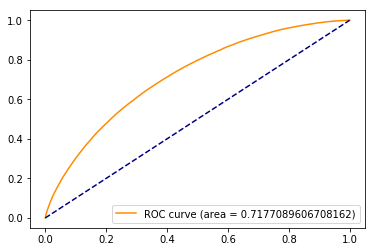

best number of trees/iterations: 702


In [144]:
# hyperlearn SVD imputation
# X_cat_nanfilled, typical best seen is .7304
predictions_probs = cat_model.predict_proba(X_test)
make_roc_plot(y_test, predictions_probs[:,1])
print('best number of trees/iterations: {0}'.format(cat_model.tree_count_))

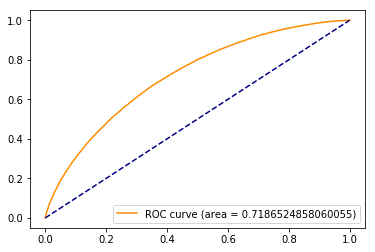

best number of trees/iterations: 464


In [27]:
# justin filling nan version
# X_cat_nanfilled, typical best seen is .7186ish
predictions_probs = cat_model.predict_proba(X_test)
make_roc_plot(y_test, predictions_probs[:,1])
print('best number of trees/iterations: {0}'.format(cat_model.tree_count_))